In [13]:
#!/usr/bin/python3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import random
import pdb
import re
import glob
from sklearn.decomposition import NMF

In [14]:
def file2Spectra(path):
    #Open and read file
    logfile =  open(path, 'r')
    logtest = logfile.read()
    logfile.close()
    # Find Frequencies with diceimal digits
    freqstri =re.findall('Frequencies\D*(\d+.\d+)\D*(\d+.\d+)\D*(\d+.\d+)',logtest) #looking for decimal numbers and spaces
    IRIntenstri =re.findall('IR Inten\D*(\d+.\d+)\D*(\d+.\d+)\D*(\d+.\d+)',logtest)
    IrDict =[]
    for freqTuple,intTuple in zip(freqstri,IRIntenstri):
        for n,p in zip(freqTuple,intTuple):
            IrDict.append( [float(n), float(p)])
    
    Irs = np.array(IrDict)
    #normalize
    Irs[:,1] = 100*Irs[:,1]/np.amax(Irs[:,1])
    return Irs


In [15]:
def IrPlotter(item,title,leg = [], multiple = False):
    if not(multiple):
        plt.plot(np.linspace(0,4000,len(item)),item,markersize=.1)
    else:
        for n in item:
            plt.plot(np.linspace(0,4000,len(n)),n,markersize=.1)
    if len (leg) > 0:
        plt.legend(leg)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("cm^-1")    
    plt.show()
    plt.clf()

In [16]:
def nmfMatcher(OG_spectra,Calc_spectra):
    #pdb.set_trace() 
        #print(len(OG_spectra))
    #OG_spectra = np.transpose(OG_spectra)
    mindim = np.amin(OG_spectra.shape)
    errorTable = np.zeros((mindim,mindim))
    for n in range (mindim):
         for p in range(mindim):
                 errorTable[n,p] += np.sum(abs( OG_spectra[n] - Calc_spectra[p]))
    #print("hi \n", errorTable)
   # print(errorTable)
    matchTable=np.zeros((mindim,mindim))
    #print("errorTable \n \n",errorTable)
    for entry in range(mindim):
         Match = np.where(np.amin(errorTable) == errorTable)
         Match = list(Match) 
         
        
         x = Match[0]
         y = Match[1]
         matchTable[entry,0] =  x
         matchTable[entry,1] =  y
         #print(Match, errorTable[Match])
         errorTable[x]=10**12
        # errorTable[1,y]=10**12
         #print(errorTable)
         #print(errorTable)
    matchTable = matchTable.astype(int)
    return matchTable



In [17]:
def VertPlotParamaters():
    plt.xlabel("Wavenumber cm^-1")
    plt.ylabel("Intensity %")
    plt.gca().invert_yaxis() 
    plt.gca().invert_xaxis()
    plt.show()
    plt.clf()
    


In [18]:
def gaussian_broadening(spectra, broaden, resolution=1):
 
    """ Performs gaussian broadening on IR spectrum
    generates attribute self.IR - np.array with dimmension 4000/resolution consisting gaussian-boraden spectrum
    
    spectra should be in numpy format or list with frequencies in 0 index then intensities in index 1
    :param broaden: (float) gaussian broadening in wn-1
    :param resolution: (float) resolution of the spectrum (number of points for 1 wn) defaults is 1, needs to be fixed in plotting
    """

    IR = np.zeros((int(4000/resolution) + 1))
    X = np.linspace(0,4000, int(4000/resolution)+1)
   # for f, i in zip(spectra[:,0], :  IR += i*np.exp(-0.5*((X-f)/int(broaden))**2)
   # self.IR=np.vstack((X, IR)).T #tspec
                    
                    
    for line in spectra:
        freq = line[0]
        inten = line[1]
        IR += inten*np.exp(-0.5*((X-freq)/int(broaden))**2)
    return IR



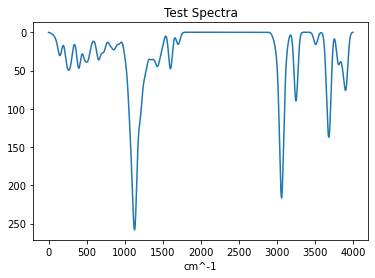

<Figure size 432x288 with 0 Axes>

In [19]:
fileList = glob.glob('Tri_A1*/Tri_A1*/input.log')
IR0 =random.choice(fileList)
IR0 = file2Spectra(IR0)
IR0 = gaussian_broadening(IR0,25,1)
IrPlotter(IR0,"Test Spectra")


In [20]:
def deriv(spec,h):
  """ calculate first derivative of function 'spec'
       using the central finite difference method up to 6th order,
       and for the first 3 and last 3 grid points the
       forward/backward finite difference method up to 2nd order.
       ...as used in f77-program and suggested by Zanazzi-Jona...
       :param spec: (list) an IR spectrum
       :param h: (float) the delta x between each data point, must be less than 1 for accurate integral results
       :return: the first derivative of the parameter spec
  """ 
  der_spec =[]
  for i in spec:
     der_spec += [i,0]
  #der_spec =[[i[0],0] for i in spec]

  length=len(spec)
  for i in range(3,length-3):
    der_spec[i]=(-1*spec[i-3]+9*spec[i-2]-45*spec[i-1]+45*spec[i+1]-9*spec[i+2]+1*spec[i+3])/(60*h)
  for i in range(0,3):
    der_spec[i]=(-11*spec[i]+18*spec[i+1]-9*spec[i+2]+2*spec[i+3])/(6*h)
  for i in range(length-3,length):
    der_spec[i]=(11*spec[i]-18*spec[i-1]+9*spec[i-2]-2*spec[i-3])/(6*h)

  return der_spec

bob (100,)


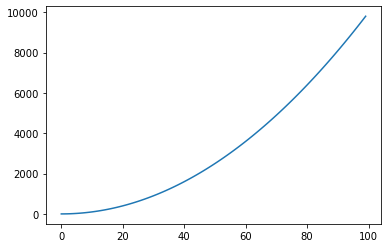

d_bob 200


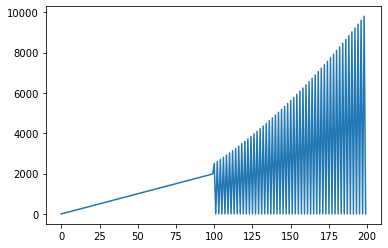

ValueError: all input arrays must have the same shape

In [21]:
bob =np.zeros(100)
for n in range(100):
    bob[n] = n**2
plt.plot(bob)
print("bob", bob.shape)
plt.show()
plt.clf()
d_bob = deriv(bob,.1)
print("d_bob", len(d_bob))
plt.plot(d_bob)
plt.show()
completeBob = np.stack((bob,d_bob))

In [22]:
def get_range(tspec,espec,w_incr,shift,start,stop):
  """determine wavenumber range within the comparison between theoretical
  and experimental spectrum is performed (depends on the shift)
  :param tspec: (list) theoretical spectrum
  :param espec: (list) experimental spectrum 
  :param w_incr: (float) grid interval of the spectra -- should be 1 or smaller!
  :param shift: the shift on the spectrum
  :param start: (int) the starting point on the spectrum
  :param stop: (int) the ending point on the spectrum
  :return: (tnstart, tnstop, enstart, enstop) the start and stop for thee range of the theoretical and experimental spectra
  """
  de1=start+shift-espec[0][0]
  if (de1 >= 0 ):
    de1=int((start+shift-espec[0][0])/w_incr+0.00001)
    enstart=de1
    tnstart=int((start-tspec[0][0])/w_incr+0.00001)
  else:
    de1=int((start+shift-espec[0][0])/w_incr-0.00001)
    enstart=0
    tnstart=int((start-tspec[0][0])/w_incr-de1+0.00001)
  de2=stop+shift-espec[-1][0]
  if (de2 <= 0 ):
    de2=int((stop+shift-espec[-1][0])/w_incr-0.00001)
    enstop=len(espec)+de2
    tnstop=len(tspec)+int((stop-tspec[-1][0])/w_incr-0.00001) 
  else:
    de2=int((stop+shift-espec[-1][0])/w_incr+0.00001)
    enstop=len(espec)
    tnstop=len(tspec)+int((stop-tspec[-1][0])/w_incr-de2-0.00001)
  return tnstart, tnstop, enstart, enstop

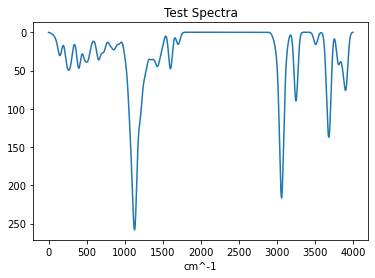

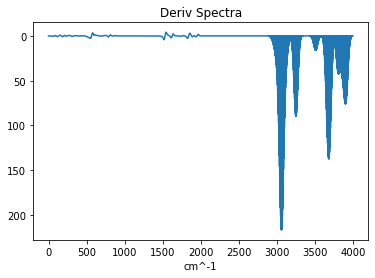

<Figure size 432x288 with 0 Axes>

In [23]:
IrPlotter(IR0,"Test Spectra")
IrPlotter(deriv(IR0,1),"Deriv Spectra")



In [24]:
def ypendry(spec,d1_spec,VI):
  """ calculate the Pendry Y-function: y= l^-1/(l^-2+VI^2) with l=I'/I (logarithmic derivative),
      J.B. Pendry, J. Phys. C: Solid St. Phys. 13 (1980) 937-44
  :param spec: (list) a conformer IR spectrum
  :param d1_spec: (list) the first derivative of the IR spectrum
  :param VI: (int) approximate half-width of the peaks
  :return: (2D list) returns the calculated pendry y-function
  """
  y=[[i[0],0] for i in spec]

  for i in range(len(spec)):
    if (abs(spec[i][1]) <= 1.E-7):
      if (abs(d1_spec[i][1]) <= 1.E-7):
        y[i][1] = 0 
      else:
        y[i][1] = (spec[i][1]/d1_spec[i][1])/((spec[i][1]/d1_spec[i][1])**2+VI**2)
    else:
      y[i][1] = (d1_spec[i][1]/spec[i][1])/(1+(d1_spec[i][1]/spec[i][1])**2*(VI**2))
  return y

The expected fractions are  0.898, 0.149.


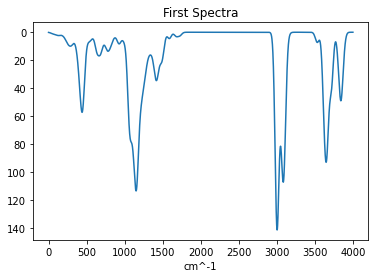

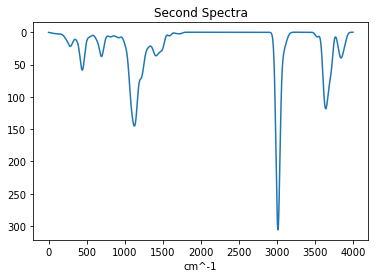

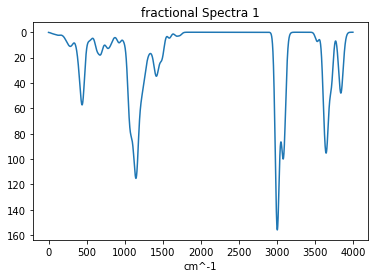

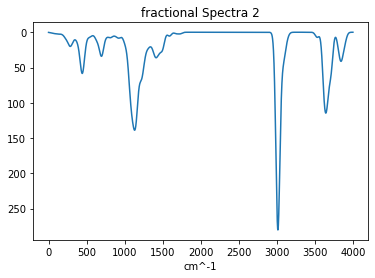

C:\Users\Abner\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 4000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


[[48.60900551 20.66945443]
 [ 9.83843156 37.15867515]]
[[1.         0.42521862]
 [0.26476809 1.        ]]


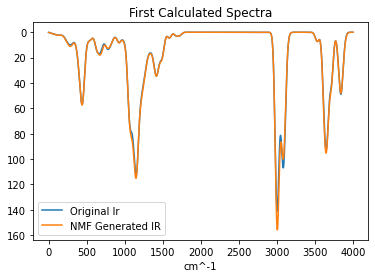

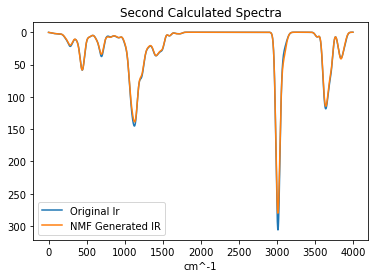

[[0 0]
 [1 1]]


(array([1.25882074e-01, 1.34831631e-01, 1.44250047e-01, ...,
        3.55117821e-05, 2.91052872e-05, 2.38167690e-05]),
 array([0.13817439, 0.14762455, 0.1575498 , ..., 0.00046897, 0.00039757,
        0.00033651]))

<Figure size 432x288 with 0 Axes>

In [25]:

fileList = glob.glob('Tri_A1*/Tri_A1*/input.log')

#print(isinstance(fileList[0],str))
#plt.vlines(file2Spectra(fileList[1])[:,0],0,file2Spectra(fileList[0])[:,1])


# In[52]:




# In[53]:




def nmf2TesterMixB():
    #pdb.set_trace()

    fraction1 = random.random()
    fraction2 = random.random()
    print(f'The expected fractions are  {fraction1:.3}, {fraction2:.3}.')
    
    #Creating Two Spectra
    IR0 =random.choice(fileList)
    IR0 = file2Spectra(IR0)
    IR0 = gaussian_broadening(IR0,25,1)
    IrPlotter(IR0,"First Spectra")

    
    IR1 =random.choice(fileList)
    IR1 = file2Spectra(IR1)
    IR1 = gaussian_broadening(IR1,25,1)
    IrPlotter(IR1,"Second Spectra")
   # print(IR1.shape)
 
    IRF = np.zeros((2,4001))
    IRF[0,:] = IR0 *fraction1 + IR1*(1-fraction1)
    IRF[1,:] = IR0 * fraction2 +  IR1*(1-fraction2)
    IrPlotter(IRF[0,:],"fractional Spectra 1")
    IrPlotter(IRF[1,:],"fractional Spectra 2")
    IRF= np.transpose(IRF)
    
    model = NMF(n_components=2, max_iter=4000, tol= 1*10**-10, solver= 'mu', init ='nndsvda', beta_loss= 'kullback-leibler' )
    W = model.fit_transform(IRF)
    H = model.components_
    Hnorm = np.apply_along_axis(lambda l :l/np.amax(l) ,1,H)
    print(H)
    print(Hnorm)
    product = np.matmul(W,H)
    matchTable = nmfMatcher (IRF, product)
    IrOrgs = [IR0,IR1]
    IrPlotter([IrOrgs[matchTable[0,0]], product[:,matchTable[0,1]]],"First Calculated Spectra", ['Original Ir', 'NMF Generated IR'],True)
    IrPlotter([IrOrgs[matchTable[1,0]] ,product[:,matchTable[1,1]]],"Second Calculated Spectra", ['Original Ir', 'NMF Generated IR'], True)      
   # IrPlotter([IROrgs[matchTable[0][0]],product
               #[W[matchTable[0][1],:]]], "First Matched Spectra", True)
    
    print(matchTable)
    return(IrOrgs[matchTable[0,0]], product[:,matchTable[0,1]])
    
   # print("Matrix product size", product.shape)
    ##print("Variable matrix", H)
   # print("Product Sizes", W.shape, IRF.shape)
    #print(nmfMatcher (IRF, product))
 
nmf2TesterMixB()


In [26]:
def rfac(espec, tspec, start=1000, stop=1800, w_incr=1.0, shift_min=-10, shift_max=+10, shift_incr=1, r="pendry", VI=10):

  """ %prog [options] r-fac.in
        Reads two spectra and calculates various R-factors -- FS 2011
        Attention: both spectra have to be given on the same, equidistant grid!
        NOTE: in the f77-program R1 is scaled by 0.75 and R2 is scaled by 0.5; this is not done here
        Please provide a file r-fac.in with the following specifications (without the comment lines!!!) 
        (the numbers are just examples, choose them according to your particular case)
  
  :param espec: (list) the experimental spectrum
  :param tspec: (list) the theoretical spectrum, the conformer spectrum that the experimental spectrum is being compared to    
  :param start: (int) where to start the comparison, default to 1000
  :param stop: (int) where to stop the comparison, default to 1800
  :param w_incr: (float) grid interval of the spectra -- should be 1 or smaller! (otherwise integrations/derivatives are not accurate) Default to 0.5
  :param shift_min: (int) minimal shift of the theoretical spectrum, default to -10
  :param shift_max: (int) maximal shift of the experimental spectrum, default to +10
  :param shift_incr: (int) shift interval, default to 1
  :param r: (string) specify which r-factor should be calculated options: pendry, ZJ, R1, R2 (give a list of the requested r-factors separated by comma). The default is "pendry"
  :param VI: (int) approximate half-width of the peaks (needed for pendry r-factor). Default to 10
  """
   #for shift in numpy.arange(shift_min,shift_max+shift_incr,shift_incr):# get the interval within the two spectra are compared
                #tnstart,tnstop,enstart,enstop = get_range(tspec,espec,w_incr,shift,start,stop) 
 
   
# perform some checks of the input data...
  if (int(shift_incr/w_incr+0.00001) == 0):
    error("Error: shift_incr cannot be smaller than w_incr!")
  if (start-espec[0][0] < 0) or (espec[-1][0]-stop < 0):
    error("check experimental spectrum!!")
  if (start-tspec[0][0] < 0) or (tspec[-1][0]-stop < 0):
    error("check theoretical spectrum!!")
  if (int((espec[-1][0]-espec[0][0])/w_incr+0.0001) != len(espec)-1 ) or (int((tspec[-1][0]-tspec[0][0])/w_incr+0.0001) != len(tspec)-1 ):
    error("check w_incr!!")

 
# cut out data points that are not needed in order to save time...
  if (espec[0][0]-(start+shift_min-w_incr*25) < 0):
    espec=espec[-1*int((espec[0][0]-(start+shift_min-w_incr*25))/w_incr-0.00001):][:]
  if (espec[-1][0]-(stop+shift_max+w_incr*25) > 0):
    espec=espec[:-1*(int((espec[-1][0]-(stop+shift_max+w_incr*25))/w_incr+0.00001)+1)][:] 
  if (tspec[0][0]-(start-w_incr*25) < 0):
    tspec=tspec[-1*int((tspec[0][0]-(start-w_incr*25))/w_incr-0.00001):][:]
  if (tspec[-1][0]-(stop+w_incr*25) > 0):
    tspec=tspec[:-1*(int((tspec[-1][0]-(stop+w_incr*25))/w_incr+0.00001)+1)][:]

   
# set negative intensity values to zero
  for i in range(0,len(espec)):
    if (espec[i][1]<0):
      espec[i][1]=0
  for i in range(0,len(tspec)):
    if (tspec[i][1]<0):
      tspec[i][1]=0
   
# start calculating derivatives...
  d1_espec = deriv(espec,w_incr)   
  d1_tspec = deriv(tspec,w_incr)
# calculate the second derivatives if the Zanazzi-Jona R-factor is requested   
  if "ZJ" in r:
    d2_tspec = deriv(d1_tspec,w_incr)
    d2_espec = deriv(d1_espec,w_incr)
# calculate Pendry Y-function if Pendry R-factor is requested      
  if "pendry" in r:
    ye = ypendry(espec,d1_espec,VI)
    yt = ypendry(tspec,d1_tspec,VI)
   


  min_pendry = [1.E100,0]
  min_r1     = [1.E100,0]
  min_r2     = [1.E100,0]
  min_zj     = [1.E100,0]
# start with loop over x-axis shifts
  for shift in np.arange(shift_min,shift_max+shift_incr,shift_incr):
    # get the interval within the two spectra are compared
    tnstart,tnstop,enstart,enstop = get_range(tspec,espec,w_incr,shift,start,stop) 
    #sys.stdout.write("\nshift: %9.3f, theory-start: %5d, theory-end: %5d, exp-start: %5d, exp-end: %5d\n" % (shift,tspec[tnstart][0],tspec[tnstop-1][0],espec[enstart][0],espec[enstop-1][0]))
    s_espec = np.array(espec[enstart:enstop]) # cut out the interval within which the comparison takes place
    s_tspec = np.array(tspec[tnstart:tnstop])
    s_d1_espec = np.array(d1_espec[enstart:enstop])
    s_d1_tspec = np.array(d1_tspec[tnstart:tnstop])
    c_scale=integrate(s_espec,w_incr)/integrate(s_tspec,w_incr)
    if "pendry" in r:
      # see J.B. Pendry, J. Phys. C: Solid St. Phys. 13 (1980) 937-44
      s_yt = np.array(yt[tnstart:tnstop]) # cut out the interval within which the comparison takes place
      s_ye = np.array(ye[enstart:enstop])
      te2 = integrate((s_yt-s_ye)**2,w_incr) # integrate (yt-ye)^2
      t2e2 = integrate(s_yt**2+s_ye**2,w_incr) # integrate yt^2+ye^2
      r_pend = te2/t2e2
      #sys.stdout.write("Pendry R-factor : %f, shift: %f\n" % (r_pend,shift))
      if (r_pend < min_pendry[0] ):
         min_pendry=[r_pend,shift]
    if "R1" in r:
      # see  M.A. van Hove, S.Y. Tong, and M.H. Elconin, Surfac Science 64 (1977) 85-95
      r1 = integrate(abs(s_espec-c_scale*s_tspec),w_incr)/integrate(abs(s_espec),w_incr)
      sys.stdout.write("R1 R-factor     : %f, shift: %f\n" % (r1,shift))
      if (r1 < min_r1[0]):
         min_r1=[r1,shift]
    if "R2" in r:
      # see  M.A. van Hove, S.Y. Tong, and M.H. Elconin, Surfac Science 64 (1977) 85-95
      r2 = integrate((s_espec-c_scale*s_tspec)**2,w_incr)/integrate(s_espec**2,w_incr)
      sys.stdout.write("R2 R-factor     : %f, shift: %f\n" % (r2,shift))
      if (r2 < min_r2[0]):
         min_r2=[r2,shift]
    if "ZJ" in r:      
      # E. Zanazzi, F. Jona, Surface Science 62 (1977), 61-88
      s_d2_tspec = np.array(d2_tspec[tnstart:tnstop])
      s_d2_espec = np.array(d2_espec[enstart:enstop])

      epsilon = 0
      for i in s_d1_espec:
        if abs(i[1]) > epsilon:
          epsilon = abs(i[1])
         
      integrand = abs(c_scale*s_d2_tspec-s_d2_espec)*abs(c_scale*s_d1_tspec-s_d1_espec)/(abs(s_d1_espec)+epsilon)
      # interpolate integrand onto 10 times denser grid, see publication by Zanazzi & Jona
      incr = 0.1*w_incr
      grid_old = np.arange(0,len(integrand))*w_incr
      grid_new = np.arange(grid_old[0],grid_old[-1]+incr,incr)
      spl = interpolate.splrep(grid_old,integrand.T[1],k=3,s=0)
      integrand_dense = interpolate.splev(grid_new,spl,der=0)
      integrand_dense = np.vstack((grid_new,integrand_dense)).T
      # calculate reduced Zanazzi-Jona R-factor r=r/0.027
      r_zj = integrate(integrand_dense,incr)/(0.027*integrate(abs(s_espec),w_incr))
      sys.stdout.write("red. ZJ R-factor: %f, shift %f\n" % (r_zj,shift))
      if (r_zj < min_zj[0]):
        min_zj=[r_zj,shift]


# find minimal r-factor and write it out
   #sys.stdout.write("\nMinimal r-factors:\n")
  if "pendry" in r:
     #sys.stdout.write("minimal r-factor: Delta = %8.5f, Pendry R-factor = %7.5f \n" % ( min_pendry[1], min_pendry[0]))
       #print  (min_pendry[1], min_pendry[0])
       #I'm adding a return statement
    return min_pendry[0]
  if "R1" in r:
    sys.stdout.write("minimal r-factor: Delta = %8.5f, R1 R-factor = %7.5f \n" % ( min_r1[1], min_r1[0]))
  if "R2" in r:
    sys.stdout.write("minimal r-factor: Delta = %8.5f, R2 R-factor = %7.5f \n" % ( min_r2[1], min_r2[0]))
  if "ZJ" in r:
    sys.stdout.write("minimal r-factor: Delta = %8.5f, ZJ R-factor = %7.5f \n" % ( min_zj[1], min_zj[0]))

In [27]:
testList = range(100)
testList2 = []
for n in range(100):
    testList += [random.randint(0,100)]

TypeError: unsupported operand type(s) for +=: 'range' and 'list'

In [29]:

fileList = glob.glob('Tri_A1*/Tri_A1*/input.log')


def  nmfNoplot():
    #pdb.set_trace()

    fraction1 = random.random()
    fraction2 = random.random()
   # print(f'The expected fractions are  {fraction1:.3}, {fraction2:.3}.')
    
    #Creating Two Spectra
    IR0 =random.choice(fileList)
    IR0 = file2Spectra(IR0)
    IR0 = gaussian_broadening(IR0,25,1)
   # IrPlotter(IR0,"First Spectra")

    
    IR1 =random.choice(fileList)
    IR1 = file2Spectra(IR1)
    IR1 = gaussian_broadening(IR1,25,1)
    #IrPlotter(IR1,"Second Spectra")
   # print(IR1.shape)
 
    IRF = np.zeros((2,4001))
    IRF[0,:] = IR0 *fraction1 + IR1*(1-fraction1)
    IRF[1,:] = IR0 * fraction2 +  IR1*(1-fraction2)
    #IrPlotter(IRF[0,:],"fractional Spectra 1")
    #IrPlotter(IRF[1,:],"fractional Spectra 2")
    IRF= np.transpose(IRF)
    
    model = NMF(n_components=2, max_iter=4000, tol= 1*10**-10, solver= 'mu', init ='nndsvda', beta_loss= 'kullback-leibler' )
    W = model.fit_transform(IRF)
    H = model.components_
    Hnorm = np.apply_along_axis(lambda l :l/np.amax(l) ,1,H)
   # print(H)
   # print(Hnorm)
    product = np.matmul(W,H)
    matchTable = nmfMatcher (IRF, product)
    IrOrgs = [IR0,IR1]
   # IrPlotter([IrOrgs[matchTable[0,0]], product[:,matchTable[0,1]]],"First Calculated Spectra", ['Original Ir', 'NMF Generated IR'],True)
   # IrPlotter([IrOrgs[matchTable[1,0]] ,product[:,matchTable[1,1]]],"Second Calculated Spectra", ['Original Ir', 'NMF Generated IR'], True)      
   # IrPlotter([IROrgs[matchTable[0][0]],product
               #[W[matchTable[0][1],:]]], "First Matched Spectra", True)
    
    #print(matchTable)
    return(IrOrgs[matchTable[0,0]], product[:,matchTable[0,1]])
    
   # print("Matrix product size", product.shape)
    ##print("Variable matrix", H)
   # print("Product Sizes", W.shape, IRF.shape)
    #print(nmfMatcher (IRF, product))
 
Testplots = nmfNoplot()


C:\Users\Abner\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 4000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [46]:
testList = [[range(100)]]
testList2 = []
for n in range(100):
    TestList2 += [[random.randrange(0,100)]]
print(testList)

[[range(0, 100)]]


In [47]:
rfac(testList, testList2)

TypeError: unsupported operand type(s) for -: 'int' and 'range'